In [1]:
from tqdm import tqdm
import random
import numpy as np
import regex as re
import pandas as pd
from typing import List
import re
from sklearn.metrics import roc_auc_score, roc_curve
from pathlib import Path
import os
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np
from sklearn.metrics import balanced_accuracy_score
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from tqdm import tqdm
from sklearn.exceptions import UndefinedMetricWarning


def bootstrap_auc(df1, df2, n_classes, n_bootstraps=1000):
    """
    Perform bootstrap analysis to compare AUC scores between two datasets.

    Implements a bootstrap method to assess the statistical
    significance of the difference in AUC scores between two datasets.
    It uses random reassignment of group labels in each bootstrap iteration to
    test the null hypothesis that the group labels do not matter (no model is better than the other).

    Parameters:
    -----------
    df1 : pandas.DataFrame
        First dataset containing 'true' and 'predicted' columns.
    df2 : pandas.DataFrame
        Second dataset containing 'true' and 'predicted' columns.
    n_classes : int
        Number of classes in the classification problem.
    n_bootstraps : int, optional (default=1000)
        Number of bootstrap iterations to perform.

    Returns:
    --------
    dict
        A dictionary containing:
        - 'p_value': The calculated one-sided p-value.
        - 'empirical_difference': The observed difference in AUC scores.
        - 'auc_1': The AUC score of the first dataset.
        - 'auc_2': The AUC score of the second dataset.
        - 'test_statistics': List of test statistics from bootstrap iterations.

    Notes:
    ------
    - This is based on Eliana's R implementation (she had implemented the binary case version)
    - The function assumes multi-class classification and uses one-vs-rest AUC scoring.
    - It uses label binarization to handle multi-class scenarios.
    - The p-value is calculated using a one-sided test.
    - The function retries failed bootstrap iterations until the specified number is reached.

    Example:
    --------
    >>> df1 = pd.DataFrame({'true': [0, 1, 2], 'predicted': [0, 2, 1]})
    >>> df2 = pd.DataFrame({'true': [1, 0, 2], 'predicted': [1, 0, 2]})
    >>> result = bootstrap_auc(df1, df2, n_classes=3)
    >>> print(f"P-value: {result['p_value']:.4f}")
    """
    combined = pd.concat([df1.assign(dataset='df1'), df2.assign(dataset='df2')])

    # binarize labels for multi-class AUC scores
    y_binary_1 = label_binarize(df1['true'], classes=range(n_classes))
    score_binary_1 = label_binarize(df1['predicted'], classes=range(n_classes))
    y_binary_2 = label_binarize(df2['true'], classes=range(n_classes))
    score_binary_2 = label_binarize(df2['predicted'], classes=range(n_classes))

    # original AUC scores
    auc_1 = roc_auc_score(y_binary_1, score_binary_1, multi_class='ovr', average='macro')
    auc_2 = roc_auc_score(y_binary_2, score_binary_2, multi_class='ovr', average='macro')
    empirical_difference = abs(auc_2 - auc_1)

    test_statistics = []
    completed_iterations = 0

    with tqdm(total=n_bootstraps) as pbar:
        while completed_iterations < n_bootstraps:
            try:
                # resample with replacement
                bootstrap_sample = combined.sample(n=len(combined), replace=True)

                # randomly reassign dataset labels
                bootstrap_sample['dataset'] = np.random.choice(['df1', 'df2'], size=len(bootstrap_sample))

                # split into two groups based on reassigned labels
                group1 = bootstrap_sample[bootstrap_sample['dataset'] == 'df1']
                group2 = bootstrap_sample[bootstrap_sample['dataset'] == 'df2']

                # label binarization for bootstrap samples
                y_binary_1 = label_binarize(group1['true'], classes=range(n_classes))
                score_binary_1 = label_binarize(group1['predicted'], classes=range(n_classes))
                y_binary_2 = label_binarize(group2['true'], classes=range(n_classes))
                score_binary_2 = label_binarize(group2['predicted'], classes=range(n_classes))

                # AUC for each group
                auc_bootstrap_1 = roc_auc_score(y_binary_1, score_binary_1, multi_class='ovr', average='macro')
                auc_bootstrap_2 = roc_auc_score(y_binary_2, score_binary_2, multi_class='ovr', average='macro')

                test_stat = abs(auc_bootstrap_2 - auc_bootstrap_1)
                test_statistics.append(test_stat)

                completed_iterations += 1
                pbar.update(1)
            except Exception as e:
                continue

    # one-sided p-value
    p_value = np.mean([ts >= empirical_difference for ts in test_statistics])

    return {
        'p_value': p_value,
        'empirical_difference': empirical_difference,
        'auc_1': auc_1,
        'auc_2': auc_2,
        'test_statistics': test_statistics
    }


def plot_results(results: dict):
    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.figure(figsize=(12, 6))

    # Plot distribution of test statistics
    for seed, res in results.items():
        sns.kdeplot(res['test_statistics'], fill=True, label=f"Seed {seed}")

    # Add a vertical line for each seed's empirical difference with different colors
    colors = ['r', 'g', 'b']  # Different colors for each seed
    for (seed, res), color in zip(results.items(), colors):
        plt.axvline(res['empirical_difference'], color=color, linestyle='--',
                    label=f"Empirical Diff (Seed {seed})")

    plt.title("Distribution of Test Statistics Across Seeds")
    plt.xlabel("Absolute Difference in AUC")
    plt.ylabel("Density")
    plt.legend()

    # Add text annotations for mean p-value and mean empirical difference
    mean_p_value = np.mean([res['p_value'] for res in results.values()])
    mean_emp_diff = np.mean([res['empirical_difference'] for res in results.values()])

    plt.text(0.05, 0.95, f"Mean p-value: {mean_p_value:.4f}\nMean empirical difference: {mean_emp_diff:.4f}",
            transform=plt.gca().transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()


def parse_log_file(log_file):
    # can handle both , and ; delimiters
    pattern = r"pid\s*[:=]\s*(\d+)[,;]\s*img_path\s*[:=]\s*(.*?\.png)[,;]\s*target\s*[:=]\s*(\d+)[,;]\s*predicted\s*[:=]\s*(\d+)"
    pattern = r"pid:\s*([\w-]+),.*?img_path:\s*(.*?\.png).*?target:\s*(\d+),.*?predicted:\s*(\d+)"
    data = {'pid': [], 'img_path': [], 'true': [], 'predicted': []}
    with open(log_file, "r") as f:
        for i, line in enumerate(f):
            matches = re.findall(pattern, line)
            if matches:
                patient_id, img_path, true, predicted = matches[0]
                data['pid'].append(patient_id)
                data['img_path'].append(img_path)
                data['true'].append(int(true))
                data['predicted'].append(int(predicted))
    df = pd.DataFrame(data)


    df = df.groupby("pid")[["true", "predicted"]].median().reset_index()
    df[["true", "predicted"]] = df[["true", "predicted"]].round().astype(int)

    return df


def get_auc_from_file(log_file: str) -> float:
    pattern = r"pid\s*[:=]\s*(\d+)[,;]\s*img_path\s*[:=]\s*(.*?\.png)[,;]\s*target\s*[:=]\s*(\d+)[,;]\s*predicted\s*[:=]\s*(\d+)"

    results = defaultdict(lambda: {"predictions": [], "slide_names": set()})
    with open(log_file, "r") as f:
        for line in f:
            matches = re.findall(pattern, line)
            if matches:
                patient_id, img_path, label, prediction = matches[0]
                patient_id = int(patient_id)
                results[patient_id]["label"] = int(label)

                results[patient_id]["predictions"].append(int(prediction))
                slide_name = img_path.split("/")[6]
                results[patient_id]["slide_names"].add(slide_name)

    for patient_id in results:
        results[patient_id]["patient scores"] = np.bincount(results[patient_id]["predictions"], minlength=2)
        del results[patient_id]["predictions"]
        results[patient_id]["score"] = np.argmax(results[patient_id]["patient scores"])
        results[patient_id]["slide_names"] = list(results[patient_id]["slide_names"])

    all_scores = [d["score"] for d in results.values()]
    all_labels = [d["label"] for d in results.values()]
    auc = roc_auc_score(all_labels, all_scores)
    return auc


def get_auc(path: str, seeds: List[int]) -> List[float]:
    aucs = []
    for seed in seeds:
        log_file = f"{path}/seed {seed}/logs__rank_0.txt"
        auc = get_auc_from_file(log_file)
        aucs.append(auc)
    return aucs

In [2]:
n_bootstraps = 100_000

## NHS Updated

In [3]:
# fix for replication
seed = 48
np.random.seed(seed)
random.seed(seed)

chips_1440 = Path("data/NHS_updated/1440")
chips_512 = Path("data/NHS_updated/512")

seeds = [128, 256, 512]
all_results = defaultdict(str)

for seed in seeds:
    path_1440 = chips_1440 / f"seed {seed}" / "logs__rank_0.txt"
    path_512 = chips_512 / f"seed {seed}" / "logs__rank_0.txt"

    results_1440 = parse_log_file(path_1440)
    results_512 = parse_log_file(path_512)

    all_labels = results_1440["true"].to_numpy()
    all_scores = results_1440["predicted"].to_numpy()
    n_classes = len(np.unique(all_labels))
    y_binary = label_binarize(all_labels, classes=range(n_classes))
    score_binary = label_binarize(all_scores, classes=range(n_classes))
    roc_auc_1440 = roc_auc_score(y_binary, score_binary, multi_class='ovr', average='macro')
    bal_acc_1440 = balanced_accuracy_score(all_labels, all_scores)

    all_labels = results_512["true"].to_numpy()
    all_scores = results_512["predicted"].to_numpy()
    n_classes = len(np.unique(all_labels))
    y_binary = label_binarize(all_labels, classes=range(n_classes))
    score_binary = label_binarize(all_scores, classes=range(n_classes))
    roc_auc_512 = roc_auc_score(y_binary, score_binary, multi_class='ovr', average='macro')
    bal_acc_512 = balanced_accuracy_score(all_labels, all_scores)

    n_classes = len(np.unique(pd.concat([results_1440['true'], results_512['true']])))
    res = bootstrap_auc(results_1440, results_512, n_classes=n_classes, n_bootstraps=n_bootstraps)
    all_results[str(seed)] = res

for seed, res in all_results.items():
    print(f"Seed {seed}: p-value = {res['p_value']:.4f}")

100%|██████████| 100000/100000 [06:33<00:00, 254.39it/s]

Seed 128: p-value = 0.0000
Seed 256: p-value = 0.1365
Seed 512: p-value = 0.0042


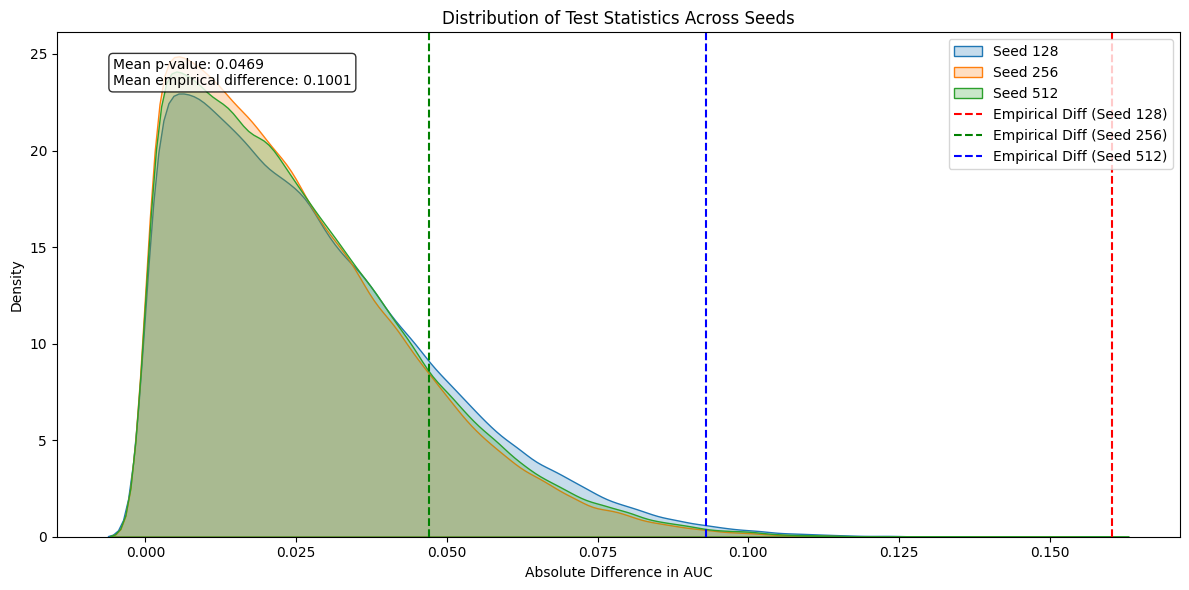

In [4]:
plot_results(all_results)

In [5]:
values = []

for seed, res in all_results.items():
    values.append(res['p_value'])

mean = np.array(values).mean()
print(f"Mean p-value {mean}")

Mean p-value 0.04691


## RCC New

In [6]:
# fix for replication
seed = 48
np.random.seed(seed)
random.seed(seed)

chips_6k = Path("data/RCC_new/6k p = 0")
chips_512 = Path("data/RCC_new/512 p = 0")
seeds = [128, 256, 512]
all_results = defaultdict(str)


for seed in seeds:
    path_6k = chips_6k / f"seed {seed}" / "logs__rank_0.txt"
    path_512 = chips_512 / f"seed {seed}" / "logs__rank_0.txt"

    results_6k = parse_log_file(path_6k)
    results_512 = parse_log_file(path_512)

    all_labels = results_6k["true"].to_numpy()
    all_scores = results_6k["predicted"].to_numpy()
    n_classes = len(np.unique(all_labels))
    y_binary = label_binarize(all_labels, classes=range(n_classes))
    score_binary = label_binarize(all_scores, classes=range(n_classes))
    roc_auc_6k = roc_auc_score(y_binary, score_binary, multi_class='ovr', average='macro')

    bal_acc_6k = balanced_accuracy_score(all_labels, all_scores)

    all_labels = results_512["true"].to_numpy()
    all_scores = results_512["predicted"].to_numpy()
    n_classes = len(np.unique(all_labels))
    y_binary = label_binarize(all_labels, classes=range(n_classes))
    score_binary = label_binarize(all_scores, classes=range(n_classes))
    roc_auc_512 = roc_auc_score(y_binary, score_binary, multi_class='ovr', average='macro')

    bal_acc_512 = balanced_accuracy_score(all_labels, all_scores)


    n_classes = len(np.unique(pd.concat([results_6k['true'], results_512['true']])))
    res = bootstrap_auc(results_6k, results_512, n_classes=n_classes, n_bootstraps=n_bootstraps)
    all_results[str(seed)] = res


for seed, res in all_results.items():
    print(f"Seed {seed}: p-value = {res['p_value']:.4f}")

100%|██████████| 100000/100000 [05:57<00:00, 279.89it/s]

Seed 128: p-value = 0.0798
Seed 256: p-value = 1.0000
Seed 512: p-value = 0.3258


/var/folders/dd/j6sl93bd7_g95s5y0d8cc2rr0000gn/T/ipykernel_3137/423594241.py:140: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(res['test_statistics'], fill=True, label=f"Seed {seed}")


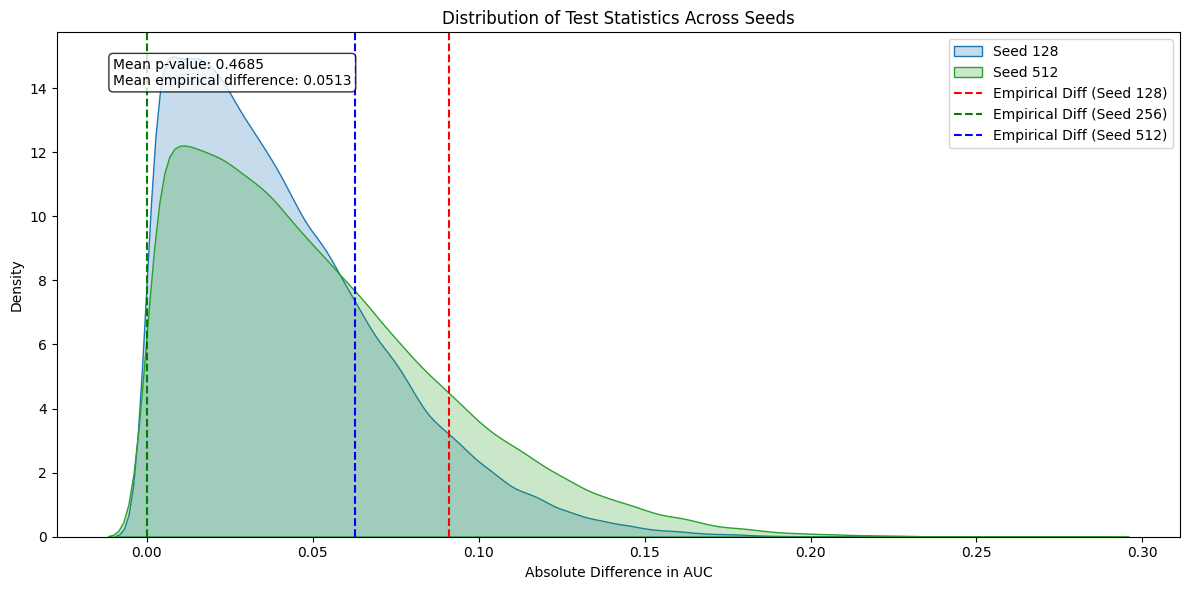

In [7]:
plot_results(all_results)

In [8]:
values = []

for seed, res in all_results.items():
    values.append(res['p_value'])

mean = np.array(values).mean()
print(f"Mean p-value {mean}")

Mean p-value 0.46853666666666666


## TCGA Colon New

In [9]:
# fix for replication
seed = 48
np.random.seed(seed)
random.seed(seed)

chips_2k = Path("data/TCGA_colon_new/2k_downsampled")
chips_6k = Path("data/TCGA_colon_new/6k")
seeds = [128, 256, 512]
all_results = defaultdict(str)


for seed in seeds:
    path_6k = chips_6k / f"seed {seed}" / "logs__rank_0.txt"
    path_2k = chips_2k / f"seed {seed}" / "logs__rank_0.txt"

    results_6k = parse_log_file(path_6k)
    results_2k = parse_log_file(path_2k)

    all_labels = results_6k["true"].to_numpy()
    all_scores = results_6k["predicted"].to_numpy()
    n_classes = len(np.unique(all_labels))
    y_binary = label_binarize(all_labels, classes=range(n_classes))
    score_binary = label_binarize(all_scores, classes=range(n_classes))
    roc_auc_6k = roc_auc_score(y_binary, score_binary, multi_class='ovr', average='macro')

    bal_acc_6k = balanced_accuracy_score(all_labels, all_scores)

    all_labels = results_2k["true"].to_numpy()
    all_scores = results_2k["predicted"].to_numpy()
    n_classes = len(np.unique(all_labels))
    y_binary = label_binarize(all_labels, classes=range(n_classes))
    score_binary = label_binarize(all_scores, classes=range(n_classes))
    roc_auc_2k = roc_auc_score(y_binary, score_binary, multi_class='ovr', average='macro')

    bal_acc_2k = balanced_accuracy_score(all_labels, all_scores)

    n_classes = len(np.unique(pd.concat([results_6k['true'], results_2k['true']])))
    res = bootstrap_auc(results_6k, results_2k, n_classes=n_classes, n_bootstraps=n_bootstraps)
    all_results[str(seed)] = res


for seed, res in all_results.items():
    print(f"Seed {seed}: p-value = {res['p_value']:.4f}")

100%|██████████| 100000/100000 [06:03<00:00, 274.97it/s]

Seed 128: p-value = 0.0506
Seed 256: p-value = 0.7197
Seed 512: p-value = 0.6736


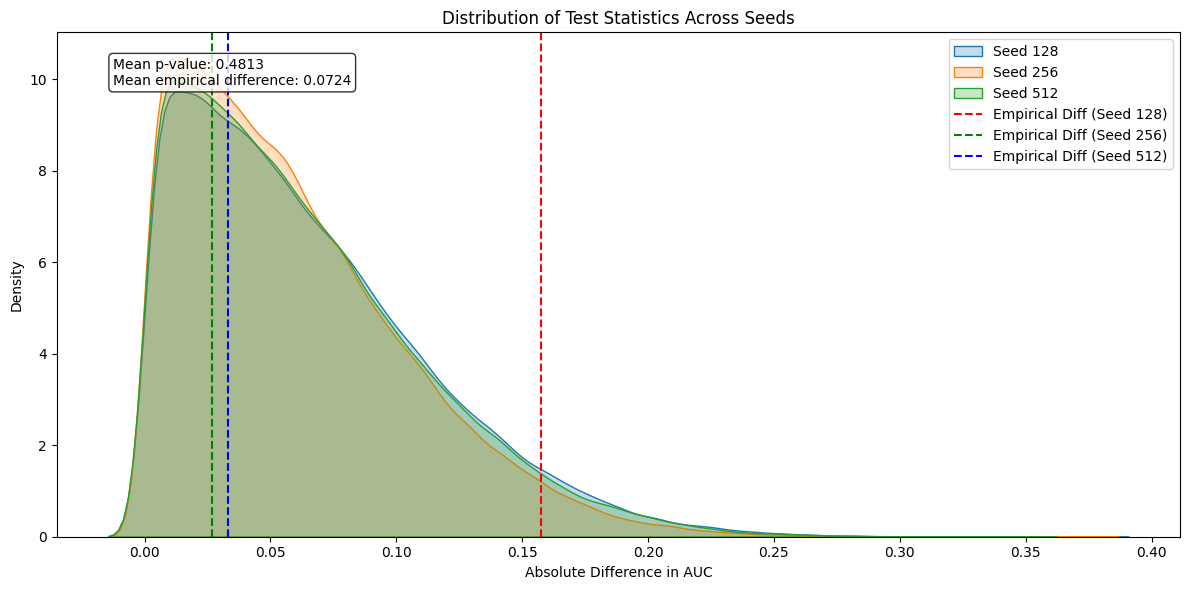

In [10]:
plot_results(all_results)

In [11]:
values = []

for seed, res in all_results.items():
    values.append(res['p_value'])

mean = np.array(values).mean()
print(f"Mean p-value {mean}")

Mean p-value 0.48129


## TCGA Renal

In [12]:
# fix for replication
seed = 48
np.random.seed(seed)
random.seed(seed)

chips_2k = Path("data/TCGA_renal/2k/")
chips_6k_512 = Path("data/TCGA_renal/6k downsampled to 512")

seeds = [128, 512]
all_results = defaultdict(str)

for seed in seeds:
    path_2k = chips_2k / f"seed {seed}" / "logs__rank_0.txt"
    path_6k_512 = chips_6k_512 / f"seed {seed}" / "logs__rank_0.txt"

    results_2k = parse_log_file(path_2k)
    results_6k_512 = parse_log_file(path_6k_512)

    all_labels = results_2k["true"].to_numpy()
    all_scores = results_2k["predicted"].to_numpy()
    n_classes = len(np.unique(all_labels))
    y_binary = label_binarize(all_labels, classes=range(n_classes))
    score_binary = label_binarize(all_scores, classes=range(n_classes))
    roc_auc_2k = roc_auc_score(y_binary, score_binary, multi_class='ovr', average='macro')
    bal_acc_2k = balanced_accuracy_score(all_labels, all_scores)

    all_labels = results_6k_512["true"].to_numpy()
    all_scores = results_6k_512["predicted"].to_numpy()
    n_classes = len(np.unique(all_labels))
    y_binary = label_binarize(all_labels, classes=range(n_classes))
    score_binary = label_binarize(all_scores, classes=range(n_classes))
    roc_auc_6k_512 = roc_auc_score(y_binary, score_binary, multi_class='ovr', average='macro')
    bal_acc_6k_512 = balanced_accuracy_score(all_labels, all_scores)

    n_classes = len(np.unique(pd.concat([results_2k['true'], results_6k_512['true']])))
    res = bootstrap_auc(results_2k, results_6k_512, n_classes=n_classes, n_bootstraps=n_bootstraps)
    all_results[str(seed)] = res

for seed, res in all_results.items():
    print(f"Seed {seed}: p-value = {res['p_value']:.4f}")

100%|██████████| 100000/100000 [06:05<00:00, 273.64it/s]

Seed 128: p-value = 0.0830
Seed 512: p-value = 0.7576


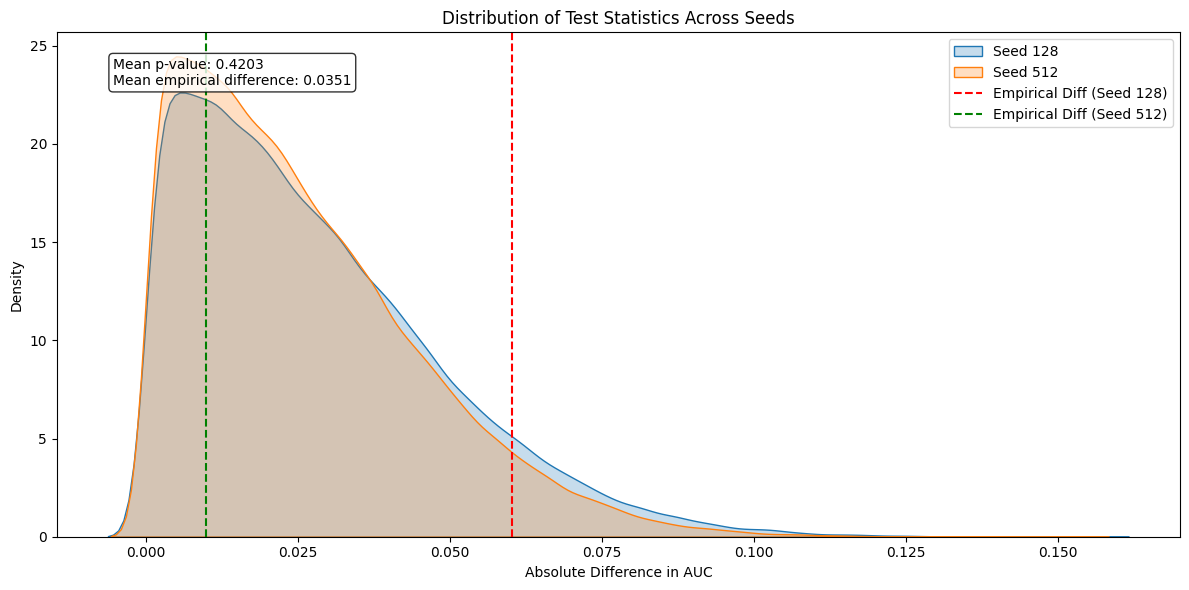

In [13]:
plot_results(all_results)

In [14]:
values = []

for seed, res in all_results.items():
    values.append(res['p_value'])

mean = np.array(values).mean()
print(f"Mean p-value {mean}")

Mean p-value 0.42033
